In [168]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from keras.models import Sequential
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import pandas as pd
import random


import warnings
warnings.filterwarnings("ignore")

In [169]:
##############################
### Getting the raw data #####
#############################

#Define the ticker symbol to get from, in our case we're getting apple stock
tickerSymbol = 'BTC-USD'
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker.
# We pick from 2021-1-1
data = tickerData.history(interval='1d', start='2010-1-1', end='2022-5-1')
data['price'] = (data['High'] + data['Low'])/2
#data.rename(columns={'Close': 'price'}, inplace=True)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,price
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,460.298004
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,434.981995
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,406.183502
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,406.589493
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,402.803497
...,...,...,...,...,...,...,...,...
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,34569088416,0,0,39299.437500
2022-04-27,38120.300781,39397.917969,37997.312500,39241.121094,30981015184,0,0,38697.615234
2022-04-28,39241.429688,40269.464844,38941.421875,39773.828125,33903704907,0,0,39605.443359


In [170]:
#################################################################
################## Creating Feature Columns #####################
#################################################################

# 1) Creating dataframe with just price and date as index
df = data[['price']]

# 2) Creating a column for log returns
df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

# 3) Creating a column that shows the position of the stock, 0 if it's going down and 1 if up
# if log returns is positive, it means it went up that day
# This will be the column used to train the deep learning model
df['position'] = np.where(df['log_returns'] > 0, 1, 0) 


# 4) Creating Lag features, Lag columns are basically the previous day(s) price depending on which lag number
# e.g lags_3 means the price 3 days ago. These are features to be passed in the model, we use 5 lags here.

def lag_column_creator(df, num_lags):
    for lag_num in range(1, num_lags + 1): 
        df[f'lags_{lag_num}'] = df['log_returns'].shift(lag_num) 
        df.dropna(inplace=True) 
    return df

df = lag_column_creator(df, 7)

# 5) Addition of Exra features
# Here we add momentum, volatility and distance as more features to our model for raining
df['momentum'] = df['log_returns'].rolling(5).mean().shift(1)
df['volatility'] = df['log_returns'].rolling(20).std().shift(1)
df['distance'] = (df['log_returns'] - df['log_returns'].rolling(50).mean()).shift(1)

#6 Dropping nuulls
df.dropna(inplace=True)

df

,price,log_returns,position,lags_1,lags_2,lags_3,lags_4,lags_5,lags_6,lags_7,momentum,volatility,distance
Date,,,,,,,,,,,,,
2014-12-05,372.473999,-0.001966,0,-0.014574,-0.005962,0.002063,0.005929,-0.005160,0.024588,-0.001323,-0.003541,0.024128,-0.013414
2014-12-06,374.696503,0.005949,1,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.005160,0.024588,-0.002902,0.022992,-0.001256
2014-12-07,374.783493,0.000232,1,0.005949,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.005160,-0.002898,0.022867,0.006253
2014-12-08,368.957489,-0.015667,0,0.000232,0.005949,-0.001966,-0.014574,-0.005962,0.002063,0.005929,-0.003264,0.021776,0.000877
2014-12-09,354.008987,-0.041359,0,-0.015667,0.000232,0.005949,-0.001966,-0.014574,-0.005962,0.002063,-0.005205,0.020960,-0.014548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,39299.437500,-0.002938,0,-0.003158,-0.002634,-0.010103,-0.035137,-0.001566,0.009624,0.032219,-0.010520,0.018511,-0.003408
2022-04-27,38697.615234,-0.015432,0,-0.002938,-0.003158,-0.002634,-0.010103,-0.035137,-0.001566,0.009624,-0.010794,0.016584,-0.003430
2022-04-28,39605.443359,0.023189,1,-0.015432,-0.002938,-0.003158,-0.002634,-0.010103,-0.035137,-0.001566,-0.006853,0.016286,-0.015467


In [171]:
###############################################################
######### Getting list of Column feature names ################
###############################################################
column_names = list(df.columns)[3:]
column_names


['lags_1',
 'lags_2',
 'lags_3',
 'lags_4',
 'lags_5',
 'lags_6',
 'lags_7',
 'momentum',
 'volatility',
 'distance']

In [172]:
########################################################
################# The Model ############################
########################################################

# 1) Segmenting the training data (doing it manually - can automate once conceptualised)
training_data = df[df.index < '2021-08-01'].copy()

# 2) Converting to normal distribution for ML z = x-mean/std
mean, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mean) / std

# 3) Segmenting and converting test data
test_data = df[df.index >= '2021-08-01'].copy()
test_data_ = (test_data - mean) / std

# 4) Setting random seed for consistency
random.seed(90)
np.random.seed(90)
tf.random.set_seed(90)

# 5) Calling the sequention deep learning model and specifying 3 layers
# Note the last layer uses sigmoid activation indicating output will be between 0 to 1
optimizer = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Dense(64, activation='relu',
              input_shape=(len(column_names),)))  
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# 6) Fitting the model
model.fit(training_data_[column_names], training_data['position'],
        verbose=False, epochs=25)



In [173]:
############# Evaluate Model's accuracy ##################
model.evaluate(training_data_[column_names], training_data['position'])

76/76 [==============================] - 0s 930us/step - loss: 0.6406 - accuracy: 0.6281


[0.640551745891571, 0.6281365752220154]

<AxesSubplot:xlabel='Date'>

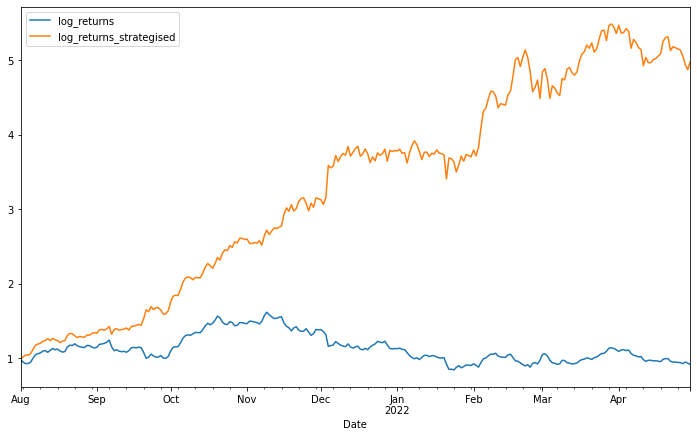

In [174]:
##################################################################
################# Predict the test data ##########################
##################################################################

# 1) Creating new column called prediction. 
# Remembering that we used sigmoid activation meaning the output that comes out is 0-1, if above .5 then round up to 1 as going up position
prediction = np.where(model.predict(test_data_[column_names]) > 0.5, 1, 0)
# Turning the prediction to 1 and -1
test_data['prediction'] = np.where(prediction > 0, 1, -1)


# 2) Creating a column called log_returns_strategised to show the estimated log returns if we followed the strategy 
# i.e. following to buy when predicted to go up, and sell when down (in an ideal world instant buying and no fees)
test_data['log_returns_strategised'] = (test_data['prediction'] * test_data['log_returns'])

# 3) Plotting the cum sum to see how effective our model would be
test_data[['log_returns', 'log_returns_strategised']].sum().apply(np.exp)
test_data[['log_returns', 'log_returns_strategised']].cumsum().apply(np.exp).plot(figsize=(12, 7))